<h1>Exploring infections through data: Interacting wtth Measles data</h1>

In this notebook I'm going to explore creating an interactive data visualisation with Bokeh. This project is born from a desire to map the historical incidence rates (per 100,000 people) of measles in the USA. The data comes from Project Tycho, a colleciton of National Notifiable Disease Surveillance System reports, and is available for free from <a href="https://www.kaggle.com/pitt/contagious-diseases/home">Kaggle</a>. But exploring and learning the Bokeh JS python API led to much more than just a map. In this project I'm going to contrast static and interactive visualisations of data whilst also exploring measle cases in the United States between 1928 and 2002.

In [2]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Import Bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LogColorMapper, ColumnDataSource, HoverTool, LinearColorMapper, ColorBar, Panel
from bokeh.palettes import Viridis6, Spectral6
from bokeh.plotting import figure
from bokeh.models.widgets import Select, Slider, Tabs, Select
from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Oranges
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.transform import factor_cmap

In [4]:
#Make notebook fullwidth
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
output_notebook()

Loading BokehJS ...

<h1>Data Wrangling</h1>

Before I start plotting anything, I need to think about the data. The measles data is contianed in a csv file called 'measles.csv'. This file contains the number of cases and the incidence rate per capita (number of new cases divided by the size of the population at risk) for each week of each year between 1928 and 2002, and for each state of the USA. I'm going to be using the python library Pandas in this project quite heavily. There is a tutorial on Pandas in the project directory that explains all the steps I've taken here.

First I'm going to take a glimpse at the data and look for formatting issues and extra columns I need to create. I then want to create two datasets that I shall use throughout the project:
* The original dataset detailing measle cases and incidence rate for each **week** of each year
* A dataset that contains the total measle cases, average measle cases, and average weekly incidence rate, **summarised for each year**

The dataset for yearly summaries will also contain geographic data for plotting the map of measles later on. I will be obtaining this geographical data from the `sampledata.us_states module`. This module generates geogrphical coordinates for state boundaries and can be used with the patches glyph (explained later) to generate maps.

In [6]:
#Import US state data from Bokeh sample data
from bokeh.sampledata.us_states import data as States

In [7]:
#Import MMR data
measles = pd.read_csv("measles.csv")

In [8]:
measles.head()

,week,state,state_name,disease,cases,incidence_per_capita
0,192801,AL,ALABAMA,MEASLES,97,3.67
1,192801,AR,ARKANSAS,MEASLES,76,4.11
2,192801,AZ,ARIZONA,MEASLES,8,1.90
3,192801,CA,CALIFORNIA,MEASLES,74,1.38
4,192801,CO,COLORADO,MEASLES,85,8.38


The 'week' column is not very helpful, it is prefixed with the year, followed by a two digit format for the week, with no spaces or delimiters dividing them. To make this information more usuable I will engineer two new columns: the week number and the year. To achieve this I am going to use the Pandas Series `apply` method, which applies a function to all values of a series (this will be explained in more detail in the Pandas tutorial). In each `apply` call I am using an anonymous function that converts each value to a string, uses string indexing to select the element of interest (the first four characters for year and the last 2 characters for week number), and returns this value as an integer.

In [9]:
measles["year"] = measles["week"].apply(lambda x: int(str(x)[0:4]))

In [10]:
measles["week_num"] = measles["week"].apply(lambda x: int(str(x)[4:7]))

With the new columns created for the time variables, I can drop the week column

In [11]:
measles.drop("week", axis = 1, inplace = True)

In [12]:
measles.head()

,state,state_name,disease,cases,incidence_per_capita,year,week_num
0,AL,ALABAMA,MEASLES,97,3.67,1928,1
1,AR,ARKANSAS,MEASLES,76,4.11,1928,1
2,AZ,ARIZONA,MEASLES,8,1.90,1928,1
3,CA,CALIFORNIA,MEASLES,74,1.38,1928,1
4,CO,COLORADO,MEASLES,85,8.38,1928,1


In the Pandas tutorial I will be deconstructing the function below completely, but the objective of this function is to basically generate thwe following summary variables based on the grouping specified:
* The total number of cases
* The average number of cases
* The weekly average incidence per capita

The function takes two arguments, the dataframe to perform the opperation on and the columns to group by.

In [13]:
def summarise(df, group_by):
    #Group data
    grouped = df.groupby(by = group_by)
    #Summarise data as Series then convert back to Dataframe
    cases_sum = pd.DataFrame(grouped["cases"].sum()).reset_index()
    cases_avg = pd.DataFrame(grouped["cases"].mean()).reset_index()
    avg_incidence_year = pd.DataFrame(grouped["incidence_per_capita"].mean()).reset_index()
    #Give columns sensible names
    avg_incidence_year = avg_incidence_year.rename(columns = {"incidence_per_capita": "avg_incidence_per_week"})
    cases_sum = cases_sum.rename(columns = {"cases": "total_cases_per_year"})
    cases_avg = cases_avg.rename(columns = {"cases": "avg_cases_per_week"})
    #Merge dataframes
    cases = pd.merge(cases_avg, cases_sum)
    new_df = pd.merge(avg_incidence_year, cases)
    return new_df

In [14]:
measles_yearly_data = summarise(measles, group_by = ["year", "state_name"])

In [15]:
measles_yearly_data.head()

,year,state_name,avg_incidence_per_week,avg_cases_per_week,total_cases_per_year
0,1928,ALABAMA,6.442115,170.057692,8843
1,1928,ARIZONA,4.779762,20.166667,847
2,1928,ARKANSAS,9.832041,181.612245,8899
3,1928,CALIFORNIA,1.331154,71.115385,3698
4,1928,COLORADO,4.312083,43.729167,2099


The call to the function above has taken the measles dataframe, grouped that dataframe on the columns 'year' and 'state_name' to create a summary dataframe that contains the following for each state/year combination:
* Average weekly incidence rate per capita
* Average cases per week
* Total cases

Later on when I am generating my map I'm going to want to access location data for each state. To simplify this process I'm going to embed the border longitude and latitude coordinates for each state, as a list, into the dataframe above. I can achieve this using the states dictionary generated from the call to `bokeh.sampledata`.

<h2>Get state location data</h2>

In the cell below I generate a dictionary of state locaiton data. The key will be the state name in uppercase (to match the current dataframe). I also remove Hawaii and Alaska, as I only want to show mainland US in my map.

In [16]:
states = {
        state["name"].upper(): state for code, state in States.items() if state["name"] not in ["Hawaii", "Alaska"]
    }

The function below, which again I will cover in more detail in the Pandas tutorial, takes a dataframe and returns a new dataframe containing the geographical coordinates for each containing state. The first step in this function is to remove Hawaii and Alaska. It then creates two new columns; latitude and longitude. This is achieved using the apply method and an anonymised function call again. Keys in the states dictionary will match the state names in the dataframe and so the state name can be used to index the dictionary data. The values from the dictionary are a list of either the latitude or longitude coordinates and it is this list which will be stored within the dataframe row.

There will be duplicated information, as the state names are duplicated for each year. Alternatively I could use the states dictionary later on and lookup the coordinates when needed. As the size of the dataframe is not critical here, I'm going to embed the data into one object to make life easier later on.

In [17]:
def state_data(df):
    df_ = df[~df["state_name"].isin(["HAWAII", "ALASKA"])]
    for z in ["lons", "lats"]:
        df_[z] = df_["state_name"].apply(lambda x: states[x][z])
    return df_

In [18]:
measles_yearly_data = state_data(measles_yearly_data)

/home/rossco/anaconda3/envs/MappingMMR/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<h1>Static plots</h1>

Before diving into the interactive world of BokehJS, lets look at some static plots and get a feel for the data. I'll create some summary datasets I can use for this and will leverage the `summarise` function I generated earlier. The creation of functions in this manner, so that they can be used later on, is a fundamental part of programming for data science.

In [19]:
measles_year = summarise(measles, group_by=["year"])

In [20]:
measles_year_week = summarise(measles, group_by=["week_num", "year"])

In [21]:
measles_year_state = summarise(measles, group_by=["year", "state_name"])

In [22]:
measles_year_week.head()

,week_num,year,avg_incidence_per_week,avg_cases_per_week,total_cases_per_year
0,1,1928,6.625952,182.071429,7647
1,1,1929,5.576829,112.146341,4598
2,1,1930,3.941591,112.045455,4930
3,1,1931,5.331860,159.837209,6873
4,1,1932,10.035476,156.357143,6567


<h3>Line plot</h3>

Lets generate a line plot, we all love a good line plot!The objective here is to see how Measles in the united states has changed over time, starting in 1928 up to 2002. To achieve this I will be using the Seaborn library in Python. I prefer this library over traditional matplotlib due to its simplicity and how it integrates well with Pandas.

There is 74 years between 1928 and 2002, which is a bit much to plot on a single line plot, and would ultimately be a bit messy. So instead I'm using the summarised data to show how the average weekly incidence per capita has changed over time, followed by the change in total cases per year. We can see the dramatic effect that the vaccination programme in the 1970s had on Measles in the US quite clearly here.

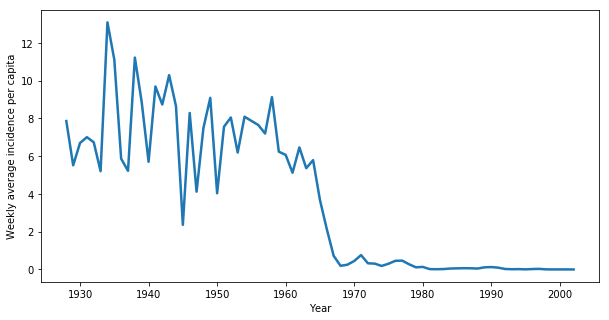

In [40]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=measles_year, linewidth = 2.5, palette="tab10", y="avg_incidence_per_week", x="year")
ax.set(xlabel='Year', ylabel='Weekly average incidence per capita')
plt.show()

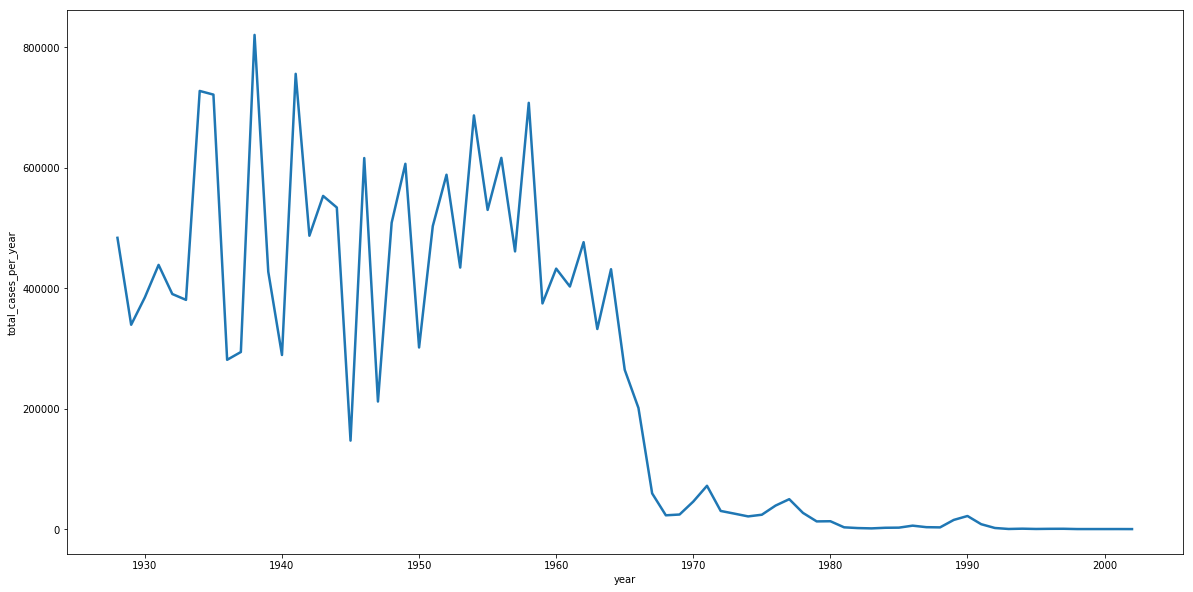

In [23]:
plt.figure(figsize=(10,10))
ax = sns.lineplot(data=measles_year, linewidth = 2.5, palette="tab10", y="total_cases_per_year", x="year")
plt.show()

<h3>Heatmap</h3>

What about state differences? Seasonal patterns? These sort of questions are not emphasised well by a line plot due to the dimensionatlity of the data. A more suitable visulatisation can be achieved using a heatmap. Generating heatmaps in Seaborn is relitively simple. You can pass the heatmap function a Pandas dataframe in a 'long'format where the axis values are given by the index and columns, and the value of each cell is the value you wish to plot on the heatmap at each given intersection. Formatting of a Pandas dataframe so that it is 'long' can be achieved with the `pivot` method. You specify which column you want to use as the index, the column that will be used to generate the new columns (each value will specify a new column), and the values for each intersection. This will return a dataframe of 'long' format.

By using a heatmap I can demonstrate seasonal patterns by plotting the year on the x-axis and the week number on the y-axis, with the severity of measles (given by the incidence per capita) at each intersection; where brighter colours indicate a higher incidence rate. Heatmaps are great for visualising 3-dimensional data like this. I can then do the same for states by plotting state names on the y-axis. This is already a highly effective method of visualisation and demonstrates both seasonal patterns that have remained consistent, as well as the dramatic effect of the vaccination programmes in the 60s and 70s.

In [24]:
heatmap_src = measles_year_week.pivot(index="week_num", columns="year", values="avg_incidence_per_week").fillna(0)

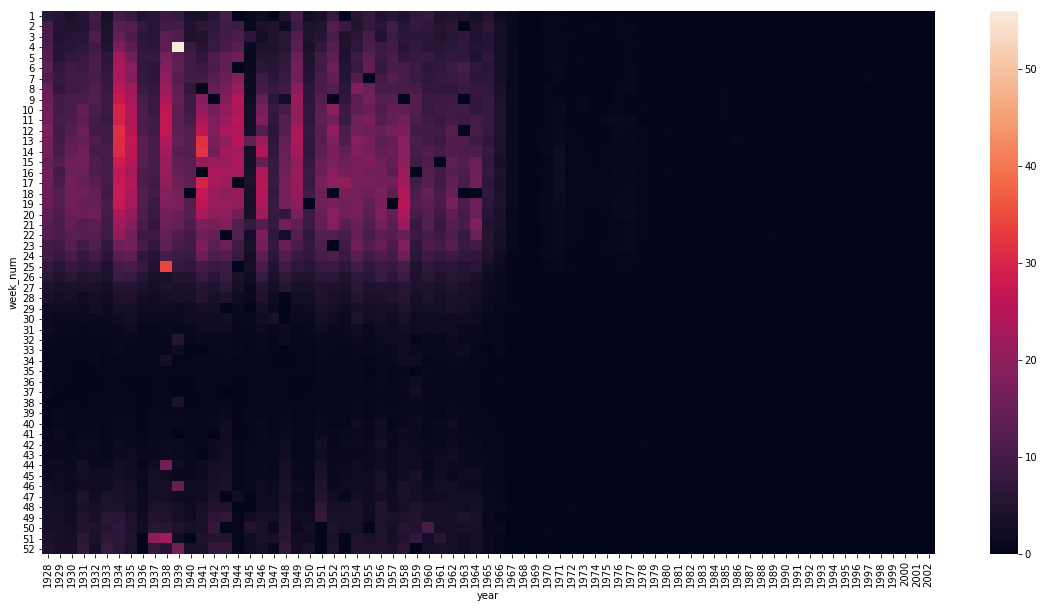

In [25]:
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(heatmap_src, annot=False, fmt="d", linewidths=0, ax=ax)
plt.show()

In [26]:
heatmap_src = measles_year_state.pivot("state_name", "year", "avg_incidence_per_week").fillna(0)

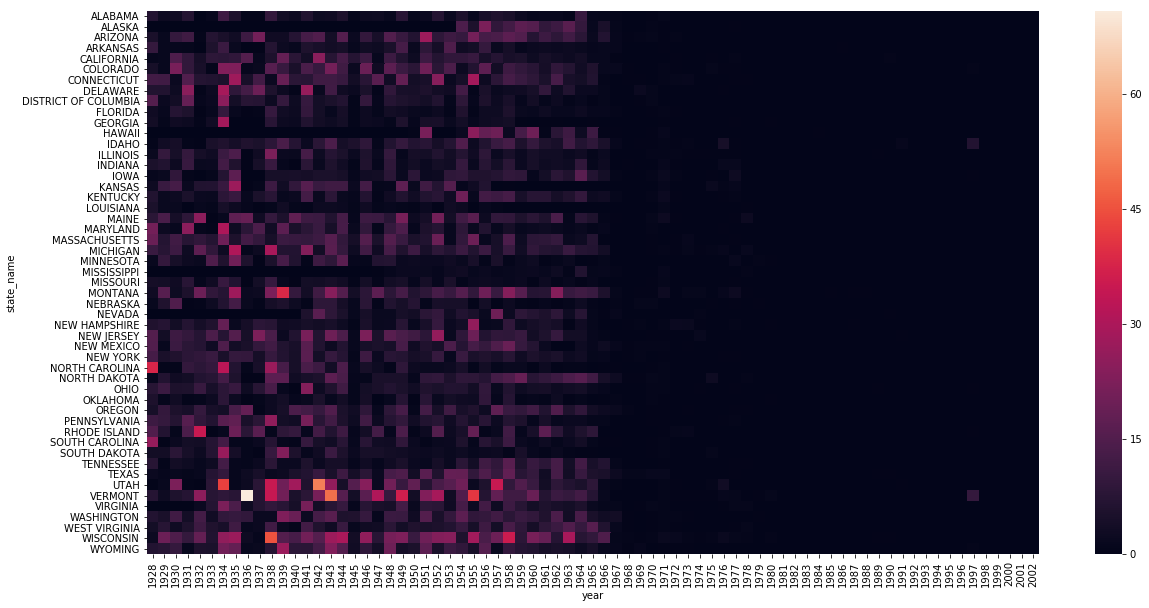

In [27]:
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(heatmap_src, annot=False, fmt="d", linewidths=0, ax=ax)
plt.show()

<h1>Static plots are boring! Lets get interactive!</h1>

Although the heatmaps are very effective at communicating the effect of vaccination on measles in the United States, I thought it would be fun to explore interactive visualisations in this project. Enlightening statistics, great models, and ensightful trends are all powerful tools but are meaningless without effective communication. When the audience has the oppertunity not just to gain a wide view of the data, but to interact with it, explore it, and ask their own questions, that is when data visualisation really becomes magical.

To achieve this I'm goint to be using the BokehJS library. BokehJS provides a powerful Python API that allows you to create interactive plots in the style of D3.js. I learnt about BokehJS mostly from the documentation and the great tutorials that they provide on their <a href="https://bokeh.pydata.org/en/latest/">website.</a>

I would also highly recommend these medium articles:
* William Koehrsen's articles on BokehJS for creating a BokehJS dashboard are fantastic, and is split into three parts: <a href="https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-one-getting-started-a11655a467d4">part 1</a>, <a href="https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-ii-interactions-a4cf994e2512">part 2</a>, and <a href="https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-iii-a-complete-dashboard-dc6a86aa6e23">part 3.</a>
* Eugine Kang gives a nice basic overview <a href="https://medium.com/@kangeugine/bokeh-rshiny-replacement-ac74694bbe3f">here.</a>
* Mandi Cai from FreecodeCamp gives a great comparison of Bokeh and D3 <a href="https://medium.freecodecamp.org/charting-the-waters-between-bokeh-and-d3-73b3ee517478"> here.</a>

For all other queries, Stackoverflow and Google usually suffice.

There is also a short Bokeh tutorial included in the directory of this project =)

For the rest of this notebook I'm going to dive into some complex Bokeh concepts which might be beyond the scope of some readers. I highly recommend going through the above resources first before proceeding.

In [25]:
def create_data(year):
    df = measles_yearly_data[measles_yearly_data["year"] == year]
    df = df.dropna()
    assert len(df) > 0, "No data for this disease and year combination"

    data = dict(
        state_name = df["state_name"],
        x = df['lons'].values.tolist(),
        y = df['lats'].values.tolist(),
        incidence_per_capita = df["avg_incidence_per_week"],
        total_cases = df["total_cases_per_year"],
        avg_cases = df["avg_cases_per_week"],
        year = df["year"]
    )

    return ColumnDataSource(data)

In [26]:
def bar_plot(src):
    states = src.data["state_name"]
    bar = figure(plot_width=800, plot_height=500, 
                 title="Total cases of Measles in the United States {}".format(src.data["year"].unique()[0]),
           x_range=states, toolbar_location=None, tools="")
    bar.xgrid.grid_line_color = None
    bar.xaxis.axis_label = "US States"
    bar.xaxis.major_label_orientation = 1.2
    bar.yaxis.axis_label = "Total measle cases"

    bar.vbar(x='state_name', top='total_cases', width=1, source=src,
           line_color="white", fill_color="#3d84f7", 
           hover_line_color="black", hover_fill_color="#4a81db")
    bar.add_tools(HoverTool(tooltips=[("Average incidence per capita per week", "@incidence_per_capita")]))

    return bar

In [27]:
def line_plot(src):
    line = figure(x_range = (1,52), plot_width=800, plot_height=500,  
                  title="Incidence of Measles in {}, {}".format(src["state_name"].unique()[0], src["year"].unique()[0]), 
               toolbar_location=None, tools="")
    line.line(x="week_num", y="incidence_per_capita", 
              line_width=2, source = src)
    line.xaxis.axis_label = "Week number"
    line.yaxis.axis_label = "Incidence per capita"
    line.circle(x="week_num", y="incidence_per_capita", size=12,
              fill_color="grey", hover_fill_color="firebrick",
              fill_alpha=0.5, hover_alpha=0.8,
              line_color=None, hover_line_color="white", source = src)

    line.add_tools(HoverTool(tooltips=[("Total cases","@cases")]))
    return line

In [28]:
source = create_data(1928)
show(bar_plot(source))

In [29]:
show(line_plot(measles[(measles["year"] == 1928) & (measles["state_name"] == "NEW YORK")]))

<h1>Making maps in Bokeh!</h1>

<h2>Build a map</h2>

In [30]:
def build_map(src):

    TOOLS = "pan,wheel_zoom,reset,hover,save"
    colors = ["#A7D49B", "#92AC86", "#696047", "#55251D", "#5A1807"]
    color_mapper = LinearColorMapper(palette=colors, low=src.data["incidence_per_capita"].min(), high=src.data["incidence_per_capita"].max())
    p = figure(
        title="US States", tools=TOOLS,
        x_axis_location=None, y_axis_location=None,
        tooltips=[
            ("Name", "@state_name"), ("Average incidences per capita", "@incidence_per_capita"), ("(Long, Lat)", "($x, $y)")
        ], plot_width=1000, plot_height=600)
    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"
    p.patches('x', 'y', source=src,
              fill_color={'field': 'incidence_per_capita', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    return p

<h2>Controlling with widgets</h2>

In [31]:
#Starting data
src = create_data(1928)

In [32]:
def update_map(attr, old, new):
    choosen_year = choose_year.value
    new_data = create_data(measles_summary, chosen_year)
    src.data.update(new_data)

<h2>Package it all together!</h2>

In [33]:
def mapping_mmr(app):
    
    def create_data(year):
        df = measles_yearly_data[measles_yearly_data["year"] == year]
        df = df.dropna()
        assert len(df) > 0, "No data for this disease and year combination"
        
        data = dict(
            state_name = df["state_name"],
            x = df['lons'].values.tolist(),
            y = df['lats'].values.tolist(),
            incidence_per_capita = df["avg_incidence_per_week"],
            total_cases = df["total_cases_per_year"],
            avg_cases = df["avg_cases_per_week"]
        )
        
        return ColumnDataSource(data)
    
    def build_map(src):

        TOOLS = "pan,wheel_zoom,reset,hover,save"
        #colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
        colors = ["#A7D49B", "#92AC86", "#696047", "#55251D", "#5A1807"]
        color_mapper = LinearColorMapper(palette=colors, low=src.data["incidence_per_capita"].min(), high=src.data["incidence_per_capita"].max())
        p = figure(
            title="US States", tools=TOOLS,
            x_axis_location=None, y_axis_location=None,
            tooltips=[
                ("Name", "@state_name"), ("Average incidences per capita per week", "@incidence_per_capita{1.11}"), 
                ("Average # of cases per week", "@avg_cases{1.11}"), ("Total cases in year", "@total_cases{1.11}")
            ], plot_width=1000, plot_height=600)
        p.grid.grid_line_color = None
        p.hover.point_policy = "follow_mouse"
        p.patches('x', 'y', source=src,
                  fill_color={'field': 'incidence_per_capita', 'transform': color_mapper},
                  fill_alpha=0.7, line_color="white", line_width=0.5)

        return p
    
    def bar_plot(src):
        states = src.data["state_name"]
        bar = figure(plot_width=800, plot_height=500, 
                     title="Total cases of Measles in the United States {}".format(src["year"]),
               x_range=states, toolbar_location=None, tools="")
        bar.xgrid.grid_line_color = None
        bar.xaxis.axis_label = "US States"
        bar.xaxis.major_label_orientation = 1.2
        bar.yaxis.axis_label = "Total measle cases"

        bar.vbar(x='state_name', top='total_cases', width=1, source=src,
               line_color="white", fill_color="#3d84f7", 
               hover_line_color="black", hover_fill_color="#4a81db")
        bar.add_tools(HoverTool(tooltips=[("Average incidence per capita per week", "@incidence_per_capita")]))

        return bar
    
    def update_map(attr, old, new):
        chosen_year = choose_year.value
        new_data = create_data(chosen_year)
        src.data.update(new_data.data)
        
    #Define Widgets
    choose_year = Slider(start=1928, end=2002, value=1928, step = 1, title = "Year")
    choose_year.on_change('value', update_map)
    
    #Select starting data
    src = create_data(1928)
    
    #Init plot and set layout
    controls = WidgetBox(choose_year)
    p = build_map(src)
    layout = column(controls, p)
    
    app.add_root(layout)
    

In [34]:
handler = FunctionHandler(mapping_mmr)
app = Application(handler)
show(app)

<h1>Creating a complete dashboard!</h1>

In [35]:
def dashboard(app):
    
    def create_data(year):
        df = measles_yearly_data[measles_yearly_data["year"] == year]
        df = df.dropna()
        assert len(df) > 0, "No data for this disease and year combination"
        
        data = dict(
            state_name = df["state_name"],
            x = df['lons'].values.tolist(),
            y = df['lats'].values.tolist(),
            incidence_per_capita = df["avg_incidence_per_week"],
            total_cases = df["total_cases_per_year"],
            avg_cases = df["avg_cases_per_week"],
            year = df["year"]
        )
        
        return ColumnDataSource(data)
    def cases_bar_plot(src):
        states = src.data["state_name"]
        bar = figure(plot_width=600, plot_height=400, 
                     title="Total cases of Measles in the United States",
               x_range=states, toolbar_location=None, tools="", y_range = (0, 110000))
        bar.xgrid.grid_line_color = None
        bar.xaxis.axis_label = "US States"
        bar.xaxis.major_label_orientation = 1.2
        bar.yaxis.axis_label = "Total measle cases"

        bar.vbar(x='state_name', top='total_cases', width=1, source=src,
               line_color="white", fill_color="#3d84f7", 
               hover_line_color="black")
        bar.add_tools(HoverTool(tooltips=[("Average incidence per capita per week", "@incidence_per_capita")]))

        return bar
    
    def incidence_bar_plot(src):
        states = src.data["state_name"]
        bar = figure(plot_width=600, plot_height=400, 
                     title="Average weekly incidence of Measles in the United States",
               x_range=states, toolbar_location=None, tools="", y_range = (0, 62))
        bar.xgrid.grid_line_color = None
        bar.xaxis.axis_label = "US States"
        bar.xaxis.major_label_orientation = 1.2
        bar.yaxis.axis_label = "Average weekly incidence per capita"

        bar.vbar(x='state_name', top='incidence_per_capita', width=1, source=src,
               line_color="white", fill_color="#3d84f7", 
               hover_line_color="black")
        bar.add_tools(HoverTool(tooltips=[("Total Measles cases", "@total_cases")]))

        return bar
    
    def build_map(src):

        TOOLS = "pan,wheel_zoom,reset,hover,save"
        #colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
        colors = ["#A7D49B", "#92AC86", "#696047", "#55251D", "#5A1807"]
        color_mapper = LinearColorMapper(palette=colors, low=src.data["incidence_per_capita"].min(), high=src.data["incidence_per_capita"].max())
        p = figure(
            title="US States", tools=TOOLS,
            x_axis_location=None, y_axis_location=None,
            tooltips=[
                ("Name", "@state_name"), ("Average incidences per capita per week", "@incidence_per_capita{1.11}"), 
                ("Average # of cases per week", "@avg_cases{1.11}"), ("Total cases in year", "@total_cases{1.11}")
            ], plot_width=1000, plot_height=800)
        p.grid.grid_line_color = None
        p.hover.point_policy = "follow_mouse"
        p.patches('x', 'y', source=src, hover_line_color="black",
                  fill_color={'field': 'incidence_per_capita', 'transform': color_mapper},
                  fill_alpha=0.7, line_color="white", line_width=0.5)

        return p
    
    def update_map(attr, old, new):
        chosen_year = choose_year.value
        new_data = create_data(chosen_year)
        src.data.update(new_data.data)
        
    #Define Widgets
    choose_year = Slider(start=1928, end=2002, value=1928, step = 1, title = "Year")
    choose_year.on_change('value', update_map)
    
    #Select starting data
    src = create_data(1928)
    
    #Init plot and set layout
    controls = WidgetBox(choose_year)
    m = build_map(src)
    b_cases = cases_bar_plot(src)
    b_incidence = incidence_bar_plot(src)
    layout = row(column(controls, m), column(b_cases, b_incidence))
    app.add_root(layout)
    

In [36]:
dashboard_handler = FunctionHandler(dashboard)
dashboard_app = Application(dashboard_handler)
show(dashboard_app)

In [37]:
total_weekly = summarise(measles, ["week_num", "year"])

In [38]:
def dashboard_line(app):
    
    def create_data(year, state):
        df = measles[(measles["year"] == year) & (measles["state_name"] == state)]
        totals = total_weekly[total_weekly["year"] == year]
        #Remove missing weeks
        weeks_in_both = set(df["week_num"]).intersection(totals["week_num"])
        df = df[df["week_num"].isin(weeks_in_both)]
        totals = totals[totals["week_num"].isin(weeks_in_both)]
        assert len(df) > 0, "No data for this state and year combination"
        data = dict(
            state_name = df["state_name"],
            incidence_per_capita_state = df["incidence_per_capita"],
            total_cases_state = df["cases"],
            incidence_per_capita_total = totals["avg_incidence_per_week"],
            total_cases_total = totals["total_cases_per_year"],
            avg_cases_total = totals["avg_cases_per_week"],
            year = df["year"],
            week_num = df["week_num"]
        )
        
        return ColumnDataSource(data)

    def line_plot(src, chosen_state):
        line = figure(x_range = (1,52), plot_width=800, plot_height=500,
                      title="Incidence of Measles", 
                      toolbar_location=None, tools="")
        line.line(x="week_num", y="incidence_per_capita_total", line_width=2, source = src, line_color="red", legend = "National weekly average incidence per capita")
        line.line(x="week_num", y="incidence_per_capita_state", line_width=2, source = src, legend = "State weekly incidence per capita")
        line.xaxis.axis_label = "Week number"
        line.yaxis.axis_label = "Incidence per capita"
        line.circle(x="week_num", y="incidence_per_capita_state", size=12, 
                    fill_color="grey", hover_fill_color="firebrick",
                    fill_alpha=0.5, hover_alpha=0.8,
                    line_color=None, hover_line_color="white", source = src)
        line.circle(x="week_num", y="incidence_per_capita_total", size=12, 
            fill_color="firebrick", hover_fill_color="firebrick",
            fill_alpha=0.3, hover_alpha=0.5,
            line_color=None, hover_line_color="white", source = src)

        line.add_tools(HoverTool(tooltips=[("Total cases (state)","@total_cases_state"), ("Total cases (national)", "@total_cases_total"),("Week", "@week_num")]))
        return line
    
    def update_map(attr, old, new):
        chosen_year = choose_year.value
        chosen_state = choose_state.value
        new_data = create_data(chosen_year, chosen_state)
        src.data.update(new_data.data)
        
    #Define Widgets
    choose_year = Slider(start=1928, end=2002, value=1928, step = 1, title = "Year")
    choose_year.on_change('value', update_map)
    states = measles["state_name"].unique()
    menu = [(state, state) for state in states]
    choose_state = Select(options=menu, value="NEW YORK", title="Choose a US State")
    choose_state.on_change('value', update_map)
    
    
    #Select starting data
    src = create_data(1928, "NEW YORK")
    
    #Init plot and set layout
    controls = WidgetBox(choose_year, choose_state)
    l = line_plot(src, choose_state.value)
    layout = column(controls, l)
    app.add_root(layout)
    

In [39]:
dashboard_handler_line = FunctionHandler(dashboard_line)
dashboard_line_app = Application(dashboard_handler_line)
show(dashboard_line_app)